In [1]:
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np
import time
K = keras.backend
import pandas as pd
import math
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn import tree
from sklearn.tree import export_graphviz,plot_tree


tf.random.set_seed(42)
np.random.seed(42)
random_state=42

In [2]:
save_path = 'save_path'
os.chdir(save_path)

X_train_omics_unlabelled = pd.read_csv("X_train_omics_unlabelled.csv",index_col=0)
X_train_omics_labelled = pd.read_csv("X_train_omics_labelled.csv",index_col=0)
X_test_omics= pd.read_csv("X_test_omics.csv",index_col=0)
X_valid_omics= pd.read_csv("X_valid_omics.csv",index_col=0)
features = np.load("feature_selection.npy",allow_pickle=True)

train_set_labelled_y= pd.read_csv("train_set_labelled_y.csv",index_col=0)
test_set_labelled_y= pd.read_csv("test_set_labelled_y.csv",index_col=0)
valid_set_labelled_y= pd.read_csv("valid_set_labelled_y.csv",index_col=0)

X_train_omics_unlabelled = X_train_omics_unlabelled[features]
X_train_omics_labelled = X_train_omics_labelled[features]
X_test_omics = X_test_omics[features]
X_valid_omics = X_valid_omics[features]

train_set_labelled_c= pd.read_csv("train_set_labelled_c.csv",index_col=0)
train_set_unlabelled_c= pd.read_csv("train_set_unlabelled_c.csv",index_col=0)
test_set_labelled_c= pd.read_csv("test_set_labelled_c.csv",index_col=0)
valid_set_labelled_c= pd.read_csv("valid_set_labelled_c.csv",index_col=0)

train_set_labelled_c = train_set_labelled_c[["age","male"]]
train_set_unlabelled_c = train_set_unlabelled_c[["age","male"]]
test_set_labelled_c = test_set_labelled_c[["age","male"]]
valid_set_labelled_c = valid_set_labelled_c[["age","male"]]

scaler = MinMaxScaler()
train_set_labelled_y = scaler.fit_transform(train_set_labelled_y)
valid_set_labelled_y = scaler.transform(valid_set_labelled_y)
test_set_labelled_y = scaler.transform(test_set_labelled_y)

valid_set_labelled_y[np.where(valid_set_labelled_y >1)] = 1
test_set_labelled_y[np.where(test_set_labelled_y >1)] = 1

train_set_labelled_c["age"] = scaler.fit_transform(train_set_labelled_c[["age"]])
train_set_unlabelled_c["age"] = scaler.transform(train_set_unlabelled_c[["age"]])
test_set_labelled_c["age"] = scaler.transform(test_set_labelled_c[["age"]])
valid_set_labelled_c["age"] = scaler.transform(valid_set_labelled_c[["age"]])

In [3]:
input_shape = X_train_omics_labelled.shape[1]

# Load best model (MMD) # 

## Custom parts ##

In [4]:
class Sampling(keras.layers.Layer):
    """reparameterization trick"""
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean   
    
    
class y_dist(keras.layers.Layer):

    """
    Custom layer that is used to learn the parameters of the distribution over y.
    
    Outputs a loss. The loss is used for training. The loss is a GMM loss.
    The mean of this is then taken to provide a per batch loss. 
        
    """
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
        
    def build(self,batch_input_shape):
        self.q1 = self.add_weight(name="q1",shape=[1,1],initializer="random_normal",trainable=True)
        self.q2 = self.add_weight(name="q2",shape=[1,1],initializer="random_normal",trainable=True)
        self.mu1 = self.add_weight(name="mu1",shape=[1,1],initializer="random_normal",trainable=True)
        self.mu2 = self.add_weight(name="mu2",shape=[1,1],initializer="random_normal",trainable=True)
        self.mu3 = self.add_weight(name="mu3",shape=[1,1],initializer="random_normal",trainable=True)
        self.tau1 = self.add_weight(name="tau1",shape=[1,1],initializer="random_normal",trainable=True)
        self.tau2 = self.add_weight(name="tau2",shape=[1,1],initializer="random_normal",trainable=True)
        self.tau3 = self.add_weight(name="tau3",shape=[1,1],initializer="random_normal",trainable=True)

        super().build(batch_input_shape)
    
    def call(self,X):
        concatenated = tf.concat([self.q1,self.q2,tf.constant(np.array(0.0).reshape(1,-1),dtype="float32")],axis=-1)
        p = K.exp(concatenated)
        p = tf.math.divide(p,K.sum(p))
        sigma_concatenated = tf.concat([self.tau1,self.tau2,self.tau3],axis=-1)
        sigma = K.exp(sigma_concatenated)
        likelihood = p[0][0]*gaussian_pdf(X,mean=self.mu1,sigma=sigma[0][0])+p[0][1]*gaussian_pdf(X,mean=self.mu2,sigma=sigma[0][1])+p[0][2]*gaussian_pdf(X,mean=self.mu3,sigma=sigma[0][2]) 
        loglik = tf.math.log(likelihood)
        loss = -loglik
        loss = tf.reduce_mean(loss)
        return loss
    
    def compute_output_shape(self,batch_input_shape):
        return tf.TensorShape(1)    
    
    
def gaussian_pdf(array,mean,sigma):
    part1 = tf.math.divide(tf.constant(np.array(1.0).reshape(1,-1),dtype="float32"),sigma*(2*math.pi)**0.5)
    part2 = K.exp(-0.5*tf.math.divide((array-mean),sigma)**2)
    return part1*part2

## Load model ##

In [5]:
save_model_path = 'save_model_path'
os.chdir(save_model_path)

variational_encoder = keras.models.load_model("variational_encoder.h5", custom_objects={
   "Sampling": Sampling
})
variational_decoder = keras.models.load_model("variational_decoder.h5")
classifier = keras.models.load_model("classifier.h5", custom_objects={
   "Sampling": Sampling
})     
y_distribution = keras.models.load_model("y_distribution.h5", custom_objects={
   "y_dist": y_dist
})    

#for the loaded MMD model. Hyperparameters can be found in the relevant notebook.
codings_size=171

# Discriminator # 

In [6]:
####### PREPARATION OF TRAINING DATA #######

#first column of label =1 if real data. Second column =1 if synthetic data. One hot encoding. 

#generate 383 synthetic data samples conditioned on y

########## Training data ###############

x_val_len = len(X_train_omics_labelled)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_sample = variational_decoder([z,train_set_labelled_y,train_set_labelled_c.to_numpy()])
label_sample = np.hstack([np.zeros((383,1)),np.ones((383,1))])
label_real = np.hstack([np.ones((383,1)),np.zeros((383,1))])

#append the real and synthetic arrays

training_X = np.concatenate((X_train_omics_labelled.to_numpy(),x_sample))
training_y = np.concatenate((train_set_labelled_y,train_set_labelled_y))
training_c = np.concatenate((train_set_labelled_c.to_numpy(),train_set_labelled_c.to_numpy()))
training_label = np.concatenate((label_real,label_sample))


########## Validation data ###############

x_val_len = len(X_valid_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_sample = variational_decoder([z,valid_set_labelled_y,valid_set_labelled_c.to_numpy()])
label_sample = np.hstack([np.zeros((88,1)),np.ones((88,1))])
label_real = np.hstack([np.ones((88,1)),np.zeros((88,1))])

#append the real and synthetic arrays

valid_X = np.concatenate((X_valid_omics.to_numpy(),x_sample))
valid_y = np.concatenate((valid_set_labelled_y,valid_set_labelled_y))
valid_c = np.concatenate((valid_set_labelled_c.to_numpy(),valid_set_labelled_c.to_numpy()))
valid_label = np.concatenate((label_real,label_sample))

In [17]:
discriminator_x = keras.layers.Input(shape=[input_shape])
discriminator_y = keras.layers.Input(shape=[1])
discriminator_c = keras.layers.Input(shape=[2])
discrimator_merged = keras.layers.concatenate([discriminator_x,discriminator_y,discriminator_c])
d = keras.layers.Dense(10, activation="elu",kernel_initializer="he_normal")(discrimator_merged)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(2,activation="softmax")(d) 

discriminator = keras.models.Model(inputs=[discriminator_x,discriminator_y,discriminator_c], outputs=[d])

In [18]:
discriminator.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=0.00001))


In [19]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [20]:
discriminator.fit((training_X,training_y,training_c),training_label, epochs=400,validation_data=((valid_X,valid_y,valid_c),valid_label),
               callbacks=[early_stopping_cb])

Train on 766 samples, validate on 176 samples
Epoch 1/400
766/766 [==============================] - 0s 477us/sample - loss: 1.0478 - val_loss: 0.9035
Epoch 2/400
766/766 [==============================] - 0s 69us/sample - loss: 1.0228 - val_loss: 0.8735
Epoch 3/400
766/766 [==============================] - 0s 63us/sample - loss: 1.0142 - val_loss: 0.8448
Epoch 4/400
766/766 [==============================] - 0s 71us/sample - loss: 1.0183 - val_loss: 0.8195
Epoch 5/400
766/766 [==============================] - 0s 69us/sample - loss: 0.9391 - val_loss: 0.7965
Epoch 6/400
766/766 [==============================] - 0s 69us/sample - loss: 0.9329 - val_loss: 0.7755
Epoch 7/400
766/766 [==============================] - 0s 68us/sample - loss: 0.8982 - val_loss: 0.7563
Epoch 8/400
766/766 [==============================] - 0s 69us/sample - loss: 0.8792 - val_loss: 0.7387
Epoch 9/400
766/766 [==============================] - 0s 63us/sample - loss: 0.8619 - val_loss: 0.7227
Epoch 10/400
766/

Below we see the results of the discriminator on a synthetic x sample (conditioned on test set y values). 

In [22]:
test_len = len(X_test_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*test_len).reshape(test_len,codings_size)
x_new_sample = variational_decoder([z,test_set_labelled_y,test_set_labelled_c.to_numpy()])
K.mean(discriminator([x_new_sample,test_set_labelled_y,test_set_labelled_c.to_numpy()])[:,1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.52022254>

Below we see the results of the discriminator on a real x sample for the above test set y values. 

In [24]:
K.mean(discriminator([X_test_omics.to_numpy(),test_set_labelled_y,test_set_labelled_c.to_numpy()])[:,1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.4714>

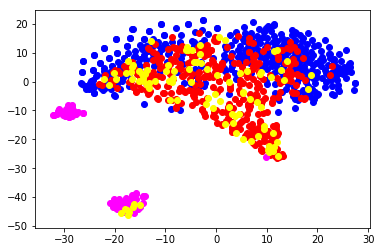

In [25]:
tsne = TSNE(random_state=42)

omics_tsne = tsne.fit_transform(np.vstack([training_X,valid_X]))

fig= plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=omics_tsne[0:383,0],y=omics_tsne[0:383,1],c="blue") #real
ax1.scatter(x=omics_tsne[383:766,0],y=omics_tsne[383:766,1],c="red") #fake
ax1.scatter(x=omics_tsne[766:846,0],y=omics_tsne[766:846,1],c="magenta") #real
ax1.scatter(x=omics_tsne[846:,0],y=omics_tsne[846:,1],c="yellow") #fake



plt.show()

#shows that real and fake data are well mixed

#### Training Discriminator on real vs random data ####

In [26]:
####### PREPARATION OF TRAINING DATA #######

#first column of label =1 if real data. Second column =1 if synthetic data. One hot encoding. 

########## Training data ###############

x_val_len = len(X_train_omics_labelled)
x_sample = np.random.uniform(size=(x_val_len,290))
label_sample = np.hstack([np.zeros((383,1)),np.ones((383,1))])
label_real = np.hstack([np.ones((383,1)),np.zeros((383,1))])

#append the real and synthetic arrays

training_X = np.concatenate((X_train_omics_labelled.to_numpy(),x_sample))
training_y = np.concatenate((train_set_labelled_y,train_set_labelled_y))
training_c = np.concatenate((train_set_labelled_c.to_numpy(),train_set_labelled_c.to_numpy()))
training_label = np.concatenate((label_real,label_sample))


########## Validation data ###############

x_val_len = len(X_valid_omics)
x_sample = np.random.uniform(size=(x_val_len,290))
label_sample = np.hstack([np.zeros((88,1)),np.ones((88,1))])
label_real = np.hstack([np.ones((88,1)),np.zeros((88,1))])

#append the real and synthetic arrays

valid_X = np.concatenate((X_valid_omics.to_numpy(),x_sample))
valid_y = np.concatenate((valid_set_labelled_y,valid_set_labelled_y))
valid_c = np.concatenate((valid_set_labelled_c.to_numpy(),valid_set_labelled_c.to_numpy()))
valid_label = np.concatenate((label_real,label_sample))

In [27]:
discriminator_x = keras.layers.Input(shape=[input_shape])
discriminator_y = keras.layers.Input(shape=[1])
discriminator_c = keras.layers.Input(shape=[2])
discrimator_merged = keras.layers.concatenate([discriminator_x,discriminator_y,discriminator_c])
d = keras.layers.Dense(10, activation="elu",kernel_initializer="he_normal")(discrimator_merged)
d = keras.layers.Dropout(0.5)(d)
d = keras.layers.Dense(2,activation="softmax")(d) 

discriminator = keras.models.Model(inputs=[discriminator_x,discriminator_y,discriminator_c], outputs=[d])

In [28]:
discriminator.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=0.0001))


In [29]:
discriminator.fit((training_X,training_y,training_c),training_label, epochs=400,validation_data=((valid_X,valid_y,valid_c),valid_label),
               callbacks=[early_stopping_cb])

Train on 766 samples, validate on 176 samples
Epoch 1/400
766/766 [==============================] - 0s 484us/sample - loss: 1.2004 - val_loss: 1.0430
Epoch 2/400
766/766 [==============================] - 0s 72us/sample - loss: 1.0163 - val_loss: 0.9443
Epoch 3/400
766/766 [==============================] - 0s 64us/sample - loss: 0.8731 - val_loss: 0.8776
Epoch 4/400
766/766 [==============================] - 0s 68us/sample - loss: 0.7554 - val_loss: 0.8289
Epoch 5/400
766/766 [==============================] - 0s 61us/sample - loss: 0.7008 - val_loss: 0.7751
Epoch 6/400
766/766 [==============================] - 0s 61us/sample - loss: 0.6248 - val_loss: 0.7261
Epoch 7/400
766/766 [==============================] - 0s 59us/sample - loss: 0.5603 - val_loss: 0.6815
Epoch 8/400
766/766 [==============================] - 0s 62us/sample - loss: 0.5449 - val_loss: 0.6539
Epoch 9/400
766/766 [==============================] - 0s 63us/sample - loss: 0.4947 - val_loss: 0.6154
Epoch 10/400
766/

In [30]:
K.mean(discriminator([X_test_omics.to_numpy(),test_set_labelled_y,test_set_labelled_c.to_numpy()])[:,0])
#80% sure real data is real


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(), dtype=float32, numpy=0.80584913>

In [31]:
x_val_len = len(X_test_omics)
x_sample = np.random.uniform(size=(x_val_len,290))
K.mean(discriminator([x_sample,test_set_labelled_y,test_set_labelled_c.to_numpy()])[:,1])
#98% sure random data is fake

<tf.Tensor: shape=(), dtype=float32, numpy=0.9947457>

# Random Forest # 

### Real vs random data ###

In [32]:
####### PREPARATION OF TRAINING DATA #######

#first column of label =1 if real data. 

########## Training data ###############

x_val_len = len(X_train_omics_labelled)
x_sample = np.random.uniform(size=(x_val_len,290))
label_sample = np.hstack([np.zeros((383,1)),np.ones((383,1))])
label_real = np.hstack([np.ones((383,1)),np.zeros((383,1))])

#append the real and synthetic arrays

training_X = np.concatenate((X_train_omics_labelled.to_numpy(),x_sample))
training_y = np.concatenate((train_set_labelled_y,train_set_labelled_y))
training_c = np.concatenate((train_set_labelled_c.to_numpy(),train_set_labelled_c.to_numpy()))
training_label = np.concatenate((label_real,label_sample))[:,0]
train_x = np.hstack([training_X,training_y,training_c])


########## Validation data ###############

x_val_len = len(X_valid_omics)
x_sample = np.random.uniform(size=(x_val_len,290))
label_sample = np.hstack([np.zeros((88,1)),np.ones((88,1))])
label_real = np.hstack([np.ones((88,1)),np.zeros((88,1))])

#append the real and synthetic arrays

valid_X = np.concatenate((X_valid_omics.to_numpy(),x_sample))
valid_y = np.concatenate((valid_set_labelled_y,valid_set_labelled_y))
valid_c = np.concatenate((valid_set_labelled_c.to_numpy(),valid_set_labelled_c.to_numpy()))
valid_label = np.concatenate((label_real,label_sample))[:,0]
valid_x = np.hstack([valid_X,valid_y,valid_c])

########### Test data ##############

x_val_len = len(X_test_omics)
test_x_random = np.random.uniform(size=(x_val_len,290)) 
test_X = np.concatenate((X_test_omics.to_numpy(),test_x_random))
test_y = np.concatenate((test_set_labelled_y,test_set_labelled_y))
test_c = np.concatenate((test_set_labelled_c.to_numpy(),test_set_labelled_c.to_numpy()))
test_x = np.hstack([test_X,test_y,test_c])

In [33]:
rfc = RandomForestClassifier(n_estimators=200,max_depth=1,n_jobs=2,random_state=random_state)

In [34]:
rfc.fit(train_x,training_label)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [35]:
rfc.score(valid_x,valid_label) #for hyperparameter tuning

0.625

In [36]:
np.mean((rfc.predict_proba(train_x))[:383,1])
#prob real train set is real

0.7768803384993493

In [37]:
np.mean((rfc.predict_proba(train_x))[383:,1])
#prob random is real

0.22124955931847182

In [38]:
np.mean((rfc.predict_proba(valid_x))[:88,1])
#prob real valid is real

0.434167636495941

In [39]:
np.mean((rfc.predict_proba(valid_x))[88:,1])
#prob random valid is real

0.2203792596868955

In [40]:
np.mean((rfc.predict_proba(test_x))[:106,1])
#prob real test set is real

0.4265574359937464

In [41]:
np.mean((rfc.predict_proba(test_x))[106:,1])
#prob random test set is real

0.24334093545772115

### Real vs Synthetic data ###

In [6]:
####### PREPARATION OF TRAINING DATA #######

#first column of label =1 if real data. 

########## Training data ###############

x_val_len = len(X_train_omics_labelled)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_sample = variational_decoder([z,train_set_labelled_y,train_set_labelled_c.to_numpy()])
label_sample = np.hstack([np.zeros((383,1)),np.ones((383,1))])
label_real = np.hstack([np.ones((383,1)),np.zeros((383,1))])

#append the real and synthetic arrays

training_X = np.concatenate((X_train_omics_labelled.to_numpy(),x_sample))
training_y = np.concatenate((train_set_labelled_y,train_set_labelled_y))
training_c = np.concatenate((train_set_labelled_c.to_numpy(),train_set_labelled_c.to_numpy()))
training_label = np.concatenate((label_real,label_sample))[:,0]
train_x = np.hstack([training_X,training_y,training_c])


########## Validation data ###############

x_val_len = len(X_valid_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_sample = variational_decoder([z,valid_set_labelled_y,valid_set_labelled_c.to_numpy()])
label_sample = np.hstack([np.zeros((88,1)),np.ones((88,1))])
label_real = np.hstack([np.ones((88,1)),np.zeros((88,1))])

#append the real and synthetic arrays

valid_X = np.concatenate((X_valid_omics.to_numpy(),x_sample))
valid_y = np.concatenate((valid_set_labelled_y,valid_set_labelled_y))
valid_c = np.concatenate((valid_set_labelled_c.to_numpy(),valid_set_labelled_c.to_numpy()))
valid_label = np.concatenate((label_real,label_sample))[:,0]
valid_x = np.hstack([valid_X,valid_y,valid_c])

############ Test data ###########

test_len = len(X_test_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*test_len).reshape(test_len,codings_size)
test_x_synthetic = variational_decoder([z,test_set_labelled_y,test_set_labelled_c.to_numpy()])
test_X = np.concatenate((X_test_omics.to_numpy(),test_x_synthetic))
test_y = np.concatenate((test_set_labelled_y,test_set_labelled_y))
test_c = np.concatenate((test_set_labelled_c.to_numpy(),test_set_labelled_c.to_numpy()))
test_x = np.hstack([test_X,test_y,test_c])



look at the decision tree graphic

In [7]:

rfc = RandomForestClassifier(n_estimators=200,max_depth=5,n_jobs=2,random_state=42)

In [8]:
rfc.fit(train_x,training_label)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [9]:
rfc.score(valid_x,valid_label)

0.9829545454545454

In [10]:
np.mean((rfc.predict_proba(train_x))[:383,1])
#prob real train set is real

0.881601370544402

In [11]:
np.mean((rfc.predict_proba(train_x))[383:,1])
#prob synthetic train set is real

0.10032235672616785

In [12]:
np.mean((rfc.predict_proba(valid_x))[:88,1])
#prob real val set is real

0.6344226742894375

In [13]:
np.mean((rfc.predict_proba(valid_x))[88:,1])

#avg prob that the synthetic valid set is synthetic

0.1463707059620457

In [14]:
np.mean((rfc.predict_proba(test_x))[:106,1])
#prob real test set is real

0.6377414792404626

In [15]:
np.mean((rfc.predict_proba(test_x))[106:,1])
#prob synthetic test set is real

0.1447929174466153

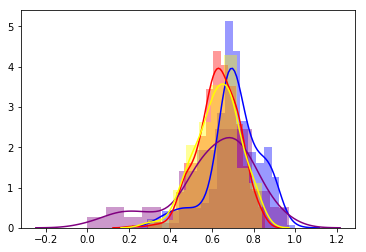

In [148]:
import seaborn 
seaborn.distplot(training_X[:383,271],color="blue") #real
seaborn.distplot(training_X[383:,271],color="red") #synthetic
seaborn.distplot(valid_X[:88,271],color="purple") #real
seaborn.distplot(valid_X[88:,271],color="yellow") #synthetic

In [53]:
dtree = rfc.estimators_[0]

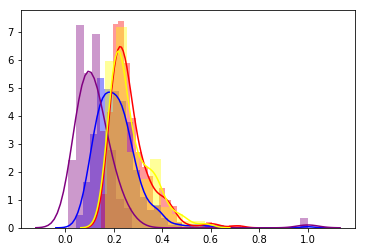

In [154]:
seaborn.distplot(training_X[:383,228],color="blue") #real
seaborn.distplot(training_X[383:,228],color="red") #synthetic
seaborn.distplot(valid_X[:88,228],color="purple") #real
seaborn.distplot(valid_X[88:,228],color="yellow") #synthetic

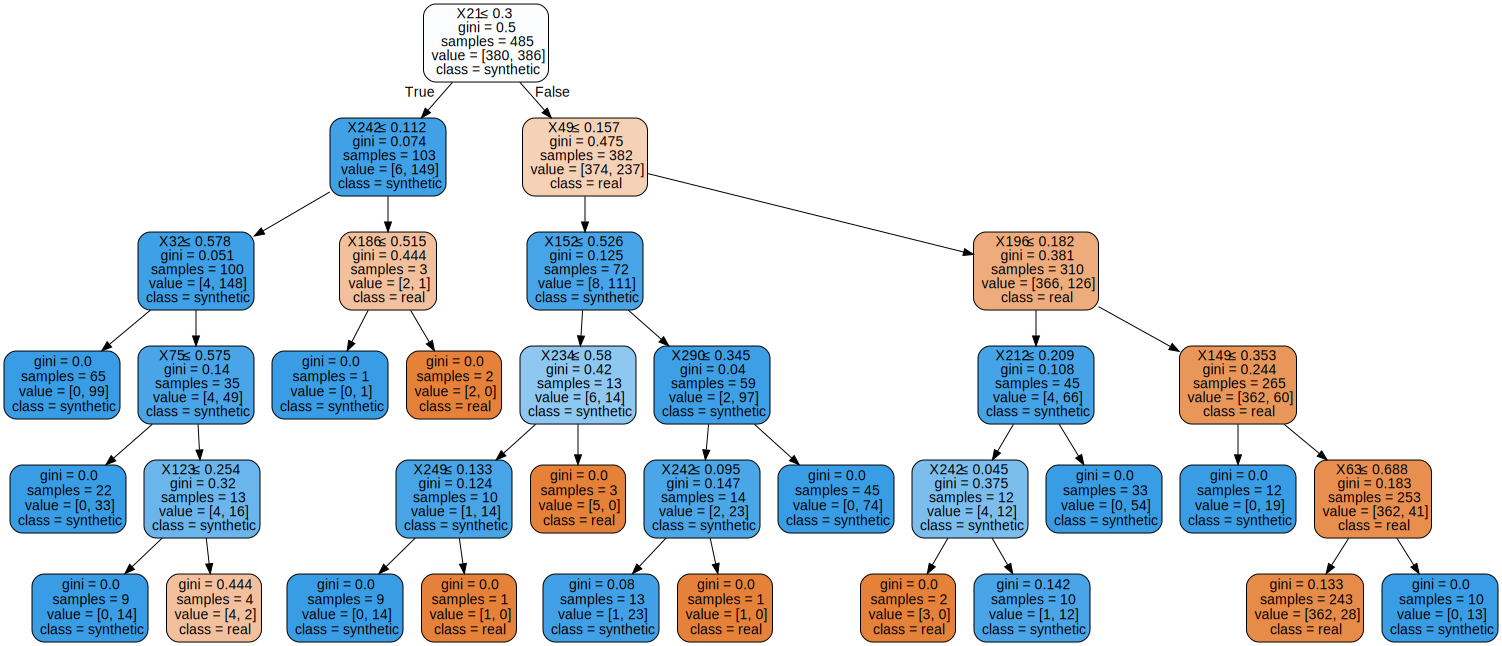

In [54]:
import graphviz
dot_data = export_graphviz(dtree, out_file=None ,
                                
         
                     filled=True, rounded=True,  
                      special_characters=True,
                          class_names=["real","synthetic"])
graph = graphviz.Source(dot_data) 
graph

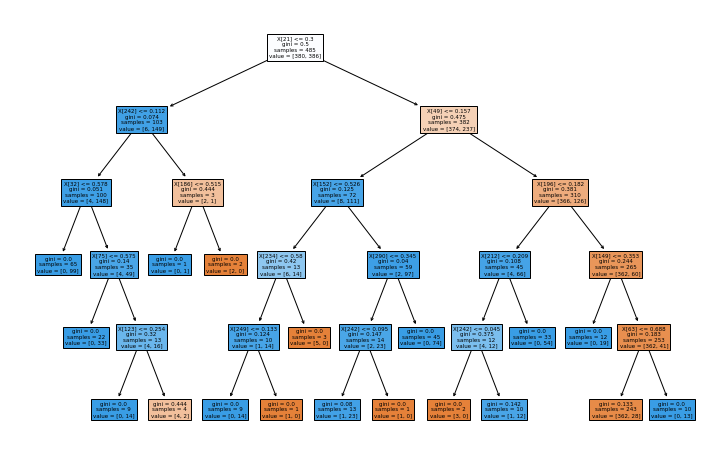

In [55]:
plt.figure(figsize=(12,8))
plot_tree(dtree,filled=True)
plt.show()